In [0]:
!nvidia-smi

Tue Apr 14 14:47:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [1]:
!pip install tensorly

     |████████████████████████████████| 71kB 2.1MB/s 
     |████████████████████████████████| 163kB 7.9MB/s 
  Created wheel for tensorly: filename=tensorly-0.4.5-cp36-none-any.whl size=100156 sha256=ba702c08c1bc2a2440b9558e96aa0ca61854e4763b5b2e1d271a91fee93fd1a7
  Stored in directory: /root/.cache/pip/wheels/44/ae/02/8d00229a4fd0af192b48d24da903f9975c7ac10e706685fc39
Successfully built tensorly


In [2]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import cv2
import tensorly as tl
import tensorly.decomposition as tld
from scipy.sparse.linalg import svds
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from functools import reduce
import pickle
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Generation of a spatial matrix

In [0]:
def gen_mat_by_gaussians(means, covs, size, nx, ny):
    size_per_dist = int(size) // len(means)
    X, Y = [], []
    for mean, cov in zip(means, covs):
        x, y = np.random.multivariate_normal(mean, cov, size_per_dist).T
        X.extend(x)
        Y.extend(y)
        
    X = np.array(X)
    Y = np.array(Y)
    # We want first dimension (rows) to be Y
    M, _, _ = np.histogram2d(Y, X, bins=(np.arange(ny), np.arange(nx)))
    
    return M

In [5]:
np.random.seed(42)

size = 800000
nx = 406
ny = 482

means = [
    [60, 60],
    [140, 90],
    [220, 300],
    [320, 400],
    [300, 150],
    [100, 200],
    [100, 400]
]

covs = [
    [[800, 0],
     [0, 800]],
    [[450, 200],
     [200, 450]],
    [[650, 100],
     [100, 850]],
    [[700, 0],
     [0, 600]],
    [[700, 300],
     [300, 600]],
    [[900, 200],
     [200, 600]],
    [[500, 50],
     [50, 500]]
]

M = gen_mat_by_gaussians(means, covs, size, nx, ny)
M.min(), M.mean(), M.max(), M.shape

(0.0, 4.086009086009086, 63.0, (481, 405))

## Add temporal evolution to the matrix and form spatio-temporal tensor (aka art_tensor)

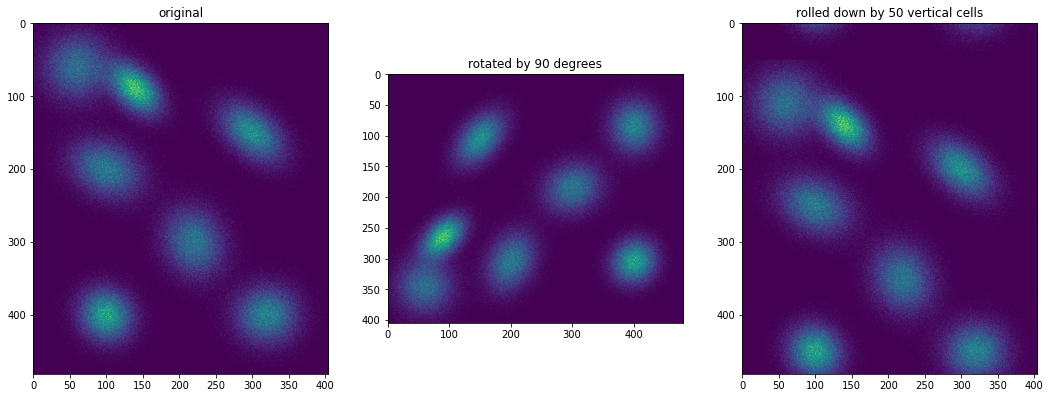

In [6]:
# We assume that matrix evolution is simply an affine transformation

fig = plt.figure(figsize=(18, 10))
ax_lst = fig.subplots(1, 3)

ax_lst[0].set_title('original')
ax_lst[0].imshow(M)

ax_lst[1].set_title('rotated by 90 degrees')
ax_lst[1].imshow(rotate(M, 90))

ax_lst[2].set_title('rolled down by 50 vertical cells')
ax_lst[2].imshow(np.roll(M, 50, axis=0))

# for ax in ax_lst:
#     ax.set_xticks([])
#     ax.set_yticks([])

In [0]:
def get_evolved_pts(src_pts, evolution_speed, evolution_angle_range):
    dst_pts = []
    for x, y in src_pts:
        r = np.random.uniform(0, evolution_speed)
        phi = np.random.uniform(evolution_angle_range[0], evolution_angle_range[1])
        dst_pts.append([x + r * np.cos(phi), y + r * np.sin(phi)])
    return np.float32(dst_pts)
    
    
def evolute_mat(X, evolution_speed, evolution_angle_range):
    y_len, x_len = X.shape
    src_pts = np.float32([[0, 0], [x_len - 1, 0], [0, y_len - 1]])
    dst_pts = get_evolved_pts(src_pts, evolution_speed, evolution_angle_range)
    affine_matrix = cv2.getAffineTransform(src_pts, dst_pts)
    X_evolved = cv2.warpAffine(X, affine_matrix, (x_len, y_len))
    return X_evolved


def create_evolution_tensor(init_mat, 
                            zsize,
                            gaussian_supplements,  # {gaussians, iters} - add flashes
                            evolution_speed=5, 
                            evolution_angle_range=[1.5 * np.pi, 2 * np.pi]):
    mat = init_mat
    tensor = [mat]
    for step_num in range(zsize - 1):
        mat = evolute_mat(mat, evolution_speed, evolution_angle_range)
        
        if step_num in gaussian_supplements['iters']:
            ind = gaussian_supplements['iters'].index(step_num)
            mat += gaussian_supplements['gaussians'][ind]
            
        tensor.append(mat)
        
    tensor = np.array(tensor)
    tensor = np.moveaxis(tensor, 0, -1)
    return tensor

In [8]:
zsize = 92
gaussian_supplements = {
    'gaussians': [
         gen_mat_by_gaussians(means=[[75, 250]],
                              covs=[[[20, 5], [5, 10]]],
                              size=size/len(means)/100,
                              nx=nx, ny=ny),
         gen_mat_by_gaussians(means=[[250, 200]],
                              covs=[[[5, 1], [1, 3]]],
                              size=size/len(means)/100,
                              nx=nx, ny=ny)
     ],
     'iters': [15, 55]
}

art_tensor = create_evolution_tensor(M, 
                                     zsize=zsize, 
                                     gaussian_supplements=gaussian_supplements,
                                     evolution_speed=2,
                                     evolution_angle_range=[0, 0.5 * np.pi])

art_tensor.shape

(481, 405, 92)

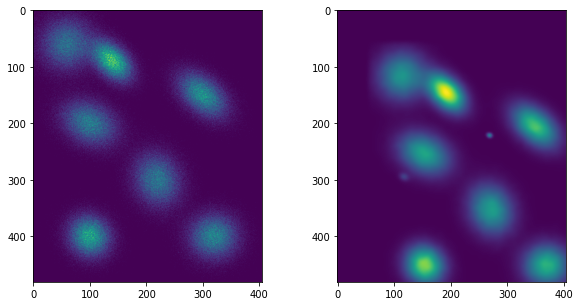

In [9]:
fig = plt.figure(figsize=(10, 5))
ax_lst = fig.subplots(1, 2)

ax_lst[0].imshow(art_tensor[:, :, 0])
ax_lst[1].imshow(art_tensor[:, :, 91])

# for ax in ax_lst:
#     ax.set_xticks([])
#     ax.set_yticks([])

In [10]:
art_tensor.mean(), art_tensor.min(), art_tensor.max(), art_tensor.std() 

(3.977093624614383, 0.0, 63.0, 6.798138629469952)

## Add noise

In [0]:
def add_noise(M, mean=0, var=1):
    copied_mat = M.copy()
    noise = np.random.normal(mean, var, size=copied_mat.shape)
    copied_mat += noise
    return copied_mat

In [0]:
noised_art_tensor = add_noise(art_tensor, mean=0, var=2)
noised_art_tensor[noised_art_tensor < 0] = 0

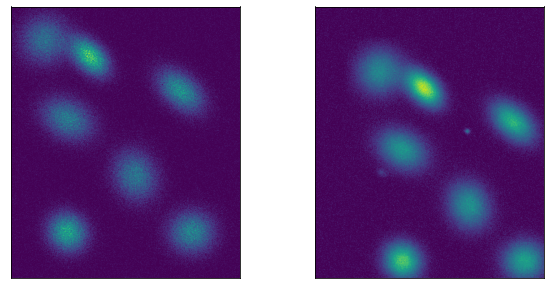

In [13]:
fig = plt.figure(figsize=(10, 5))
ax_lst = fig.subplots(1, 2)

ax_lst[0].imshow(noised_art_tensor[:, :, 0])
ax_lst[1].imshow(noised_art_tensor[:, :, 90])

for ax in ax_lst:
    ax.set_xticks([])
    ax.set_yticks([])

In [14]:
noised_art_tensor.mean(), noised_art_tensor.min(), noised_art_tensor.max(), noised_art_tensor.std() 

(4.411556804888887, 0.0, 64.13297358383046, 6.746888360616941)

## Data preprocessing

In [0]:
def tensorify(X, y, shape):
    tensor = np.full(shape, np.nan)

    for i, d in enumerate(X):
        lat, lon, t = d.astype(np.int)
        tensor[lat, lon, t] = y[i]

    return tensor

def detensorify(tensor, return_Xy=False):
    shape = tensor.shape
    t_range = np.arange(shape[2])
    lats_range = np.arange(shape[0])
    lons_range = np.arange(shape[1])

    lat = np.array([lat for _ in t_range for lat in lats_range for _ in lons_range])
    lon = np.array([lon for _ in t_range for _ in lats_range for lon in lons_range])
    t = np.array([t for t in t_range for _ in lats_range for _ in lons_range])
    y = np.moveaxis(tensor, -1, 0).flatten()

    df = pd.DataFrame({
        'lon': lon,
        'lat': lat,
        't': t,
        'y': y
    })

    if return_Xy:
        return df[['lat', 'lon', 't']], df['y']
    else:
        return df

# We now we assume that clouds are uniformly distributed, it's obviously not natural,
# but to keep things simple we accept that on the artificial stage
def add_clouds(art_tensor, cloud_coverage_percentage, supplement=np.array([]), return_Xy=False):
    cloud_art_tensor = art_tensor.copy()

    for t in range(art_tensor.shape[2]):
        mat = cloud_art_tensor[:, :, t]
        cloud_size = int(mat.size*cloud_coverage_percentage/100)
        x_inds = np.random.randint(0, mat.shape[1], size=cloud_size)
        y_inds = np.random.randint(0, mat.shape[0], size=cloud_size)
        for x, y in zip(x_inds, y_inds):
            mat[y, x] = np.nan
        cloud_art_tensor[:, :, t] = mat

    for lat, lon, t in supplement.astype(np.int):
        cloud_art_tensor[lat, lon, t] = np.nan
        
    return detensorify(cloud_art_tensor, return_Xy=return_Xy)

Generate data

In [0]:
noised_art_df = detensorify(noised_art_tensor)

Divide data on train/test set

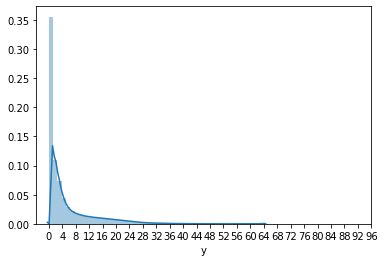

In [54]:
test_size = 0.08

d = sns.distplot(noised_art_df['y'])
d.set(xticks=list(range(0, 100, 4)))
print()

In [0]:
bins = np.array([-1e-2, 1, 2, 5, 15, 200])

In [57]:
print('Test size per one bin: ', noised_art_df['y'].shape[0] * test_size / (len(bins) - 1), '\nMax y: ', noised_art_df['y'].max())

Test size per one bin:  286752.96 
Max y:  64.13297358383046


In [58]:
pd.cut(noised_art_df['y'], bins=bins, labels=np.arange(len(bins) - 1)).value_counts()

0    7522150
2    3614249
3    2976039
1    2159875
4    1649747
Name: y, dtype: int64

In [59]:
noised_art_df['bin'] = pd.cut(noised_art_df['y'], bins=bins, labels=np.arange(len(bins) - 1))
noised_art_df.head()

,lon,lat,t,y,bin
0,0,0,0,1.638814,1
1,1,0,0,4.511140,2
2,2,0,0,0.000000,0
3,3,0,0,2.947907,2
4,4,0,0,2.199674,2


In [0]:
def uniformly_binned_train_test_split(X, y, test_size):
    all_size = y.shape[0]
    bins = X['bin'].unique()
    bin_size = np.floor(all_size * test_size / len(bins)).astype(np.int)
    X_train = pd.DataFrame(columns=X.columns, dtype=np.float64)
    y_train = pd.Series(dtype=np.float64)
    X_test = pd.DataFrame(columns=X.columns, dtype=np.float64)
    y_test = pd.Series(dtype=np.float64)


    for b in bins:
      X_train_bin = X[X['bin'] == b].copy()
      y_train_bin = y[X_train_bin.index].copy()

      X_test_bin = X_train_bin.sample(bin_size)
      y_test_bin = y_train_bin[X_test_bin.index].copy()

      X_train_bin.drop(index=X_test_bin.index, inplace=True)
      y_train_bin.drop(index=y_test_bin.index, inplace=True)

      X_train = pd.concat([X_train, X_train_bin])
      y_train = pd.concat([y_train, y_train_bin])

      X_test = pd.concat([X_test, X_test_bin])
      y_test = pd.concat([y_test, y_test_bin])

    X_train.drop('bin', inplace=True, axis=1)
    X_test.drop('bin', inplace=True, axis=1)

    return X_train, X_test, y_train, y_test

In [66]:
X_train, X_test, y_train, y_test = uniformly_binned_train_test_split(noised_art_df[['lat', 'lon', 't', 'bin']],
                                                                     noised_art_df['y'], 
                                                                     test_size=test_size)

X_test.head()

,lat,lon,t
11544001,124.0,286.0,59.0
17426229,218.0,294.0,89.0
5296994,91.0,404.0,27.0
5427873,415.0,63.0,27.0
10927750,46.0,40.0,56.0


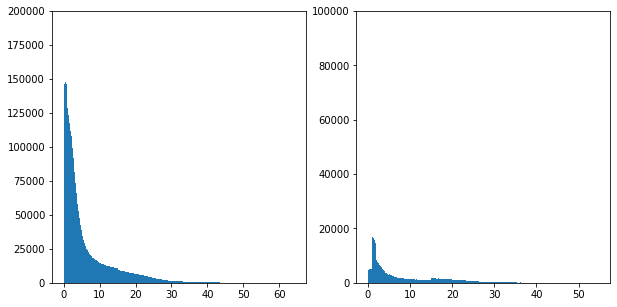

In [28]:
fig = plt.figure(figsize=(10, 5))
ax_lst = fig.subplots(1, 2)

ax_lst[0].hist(y_train, bins=1000)
ax_lst[0].set_ylim([0, 2*1e5])
ax_lst[1].hist(y_test, bins=1000)
ax_lst[1].set_ylim([0, 1e5])
print()

Add some clouds to train data

In [71]:
X_train, y_train = add_clouds(
    to_tensor(X_train.to_numpy(), 
              y_train.to_numpy(), 
              shape=noised_art_tensor.shape), 
    cloud_coverage_percentage=30,
    supplement=X_test.to_numpy(),
    return_Xy=True
)
X_train.head()

,lat,lon,t
0,0,0,0
1,0,1,0
2,0,2,0
3,0,3,0
4,0,4,0


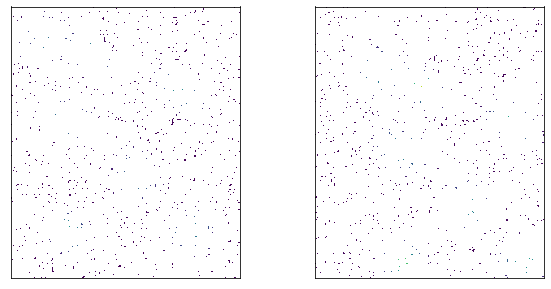

In [77]:
cloud_noised_art_tensor = tensorify(X_train.to_numpy(), y_train.to_numpy(), shape=noised_art_tensor.shape)

fig = plt.figure(figsize=(10, 5))
ax_lst = fig.subplots(1, 2)

ax_lst[0].imshow(cloud_noised_art_tensor[:, :, 0])
ax_lst[1].imshow(cloud_noised_art_tensor[:, :, 90])

for ax in ax_lst:
    ax.set_xticks([])
    ax.set_yticks([])

## DINEOF

In [0]:
# Implement DINEOF estimator
class DINEOF(BaseEstimator):
    def __init__(self, K=5,
                 original_tensor=noised_art_tensor,
                 nitemax=300, toliter=1e-3, tol=1e-8, to_center=True, 
                 keep_positive_only=True):
        self.K = K
        self.nitemax = nitemax
        self.toliter = toliter
        self.tol = tol
        self.to_center = to_center
        self.keep_positive_only = keep_positive_only
        self.info = ""
        self.original_tensor = original_tensor
        self.reconstructed_tensor = None
        self.singular_values_ = None
        self.ucomponents_ = None
        self.vtcomponents_ = None
        
    def score(self, X, y):
        y_hat = self.predict(X)
        meaned_sqd_diff = np.mean(np.power(y_hat - y, 2))
        # "-" to get bigger values for better fit (according to sklearn)
        return -np.sqrt(meaned_sqd_diff) / np.std(y)
        
    def predict(self, X):
        output = np.array([self.reconstructed_tensor[data[0], data[1], data[2]] for data in X])
        return output
        
    def fit(self, X, y):
        # X - in format (lat, lon, t) here
        # Target of this func to prepare input for _fit
        tensor = np.full(self.original_tensor.shape, np.nan)
        for i, data in enumerate(X):
            lat, lon, t = data
            tensor[lat, lon, t] = y[i]
        
        self._fit(self.rectify_tensor(tensor))
        
    def _fit(self, X):
        global dineof_stats
        global final_dineof_stats

        # X - as 2D image here
        if self.to_center:
            X, *means = self.center_2d_mat(X)

        # Initial guess
        nan_mask = np.isnan(X)
        X[nan_mask] = 0

        conv_error = 0
        for i in tqdm(range(self.nitemax)):
            u, s, vt = svds(X, k=self.K, tol=self.tol)
            X_hat = u @ np.diag(s) @ vt
            X_hat[~nan_mask] = X[~nan_mask]
            diff_in_clouds = X_hat[nan_mask] - X[nan_mask]
            new_conv_error = np.linalg.norm(diff_in_clouds) / np.std(X[~nan_mask])
            X = X_hat
            dineof_stats.append([self.K, i, new_conv_error])
            if (new_conv_error <= self.toliter) or (abs(new_conv_error - conv_error) < self.toliter):
                break
            conv_error = new_conv_error

        if self.to_center:
            X = self.decenter_2d_mat(X, *means)

        if self.keep_positive_only:
            X[X < 0] = 0

        self.info += f'iter made: {i}, convergence error: {new_conv_error:.04f}\n'
        final_dineof_stats.append([self.K, i, conv_error])
        self.reconstructed_tensor = self.unrectify_mat(X, spatial_shape=self.original_tensor.shape[:-1])
        self.singular_values_ = s
        self.ucomponents_ = u
        self.vtcomponents_ = vt
    
    def rectify_tensor(self, tensor):
        rect_mat = []
        for t in range(tensor.shape[-1]):
            rect_mat.append(tensor[:, :, t].flatten())
        rect_mat = np.array(rect_mat)
        rect_mat = np.moveaxis(rect_mat, 0, -1)
        return rect_mat

    def unrectify_mat(self, mat, spatial_shape):
        tensor = []

        for t in range(mat.shape[-1]):
            col = mat[:, t]
            unrectified_col = col.reshape(spatial_shape)
            tensor.append(unrectified_col)

        tensor = np.array(tensor)
        tensor = np.moveaxis(tensor, 0, -1)

        return tensor

    def center_2d_mat(self, mat):
        nan_mask = np.isnan(mat)
        temp_mat = mat.copy()
        temp_mat[nan_mask] = 0

        m0 = temp_mat.mean(axis=0)
        for i in range(temp_mat.shape[0]):
            temp_mat[i, :] -= m0

        m1 = temp_mat.mean(axis=1)
        for i in range(temp_mat.shape[1]):
            temp_mat[:, i] -= m1

        temp_mat[nan_mask] = np.nan
        return temp_mat, m0, m1

    def decenter_2d_mat(self, mat, m0, m1):
        temp_mat = mat.copy()

        for i in range(temp_mat.shape[0]):
            temp_mat[i, :] += m0

        for i in range(temp_mat.shape[1]):
            temp_mat[:, i] += m1

        return temp_mat

## DINEOF3

In [0]:
class DINEOF3(BaseEstimator):
    def __init__(self, R=(3, 3, 3), decomp_type='HOOI', hooi_iter_max=100,
                 original_tensor=noised_art_tensor,
                 nitemax=300, toliter=1e-3, tol=1e-8, to_center=True, 
                 keep_positive_only=True):
        self.R = R
        self.decomp_type = decomp_type
        self.hooi_iter_max = hooi_iter_max
        self.nitemax = nitemax
        self.toliter = toliter
        self.tol = tol
        self.to_center = to_center
        self.keep_positive_only = keep_positive_only
        self.info = ""
        self.original_tensor = original_tensor
        self.reconstructed_tensor = None
        self.core_tensor = None
        self.factors = None
        
    def score(self, X, y):
        y_hat = self.predict(X)
        meaned_sqd_diff = np.mean(np.power(y_hat - y, 2))
        # "-" to get bigger values for better fit (according to sklearn)
        return -np.sqrt(meaned_sqd_diff) / np.std(y)
        
    def predict(self, X):
        output = np.array([self.reconstructed_tensor[data[0], data[1], data[2]] for data in X])
        return output
    
    def fit(self, X, y):
        # X - in format (lat, lon, t) here
        # Target of this func to prepare input for _fit
        tensor = np.full(self.original_tensor.shape, np.nan)
        for i, data in enumerate(X):
            lat, lon, t = data
            tensor[lat, lon, t] = y[i]
        
        self._fit(tensor)
    
    def _fit(self, tensor):
        global dineof3_stats
        global final_dineof3_stats

        if self.to_center:
            tensor, *means = self.center_3d_tensor(tensor)

        # Initial guess
        nan_mask = np.isnan(tensor)
        tensor[nan_mask] = 0

        conv_error = 0
        for i in tqdm(range(self.nitemax)):
            if self.decomp_type == 'HOOI':
                G, A = tld.partial_tucker(tensor, modes=list(range(len(self.R))), ranks=self.R, tol=self.tol, 
                                                       n_iter_max=self.hooi_iter_max)
            elif self.decomp_type == 'truncHOSVD':
                G, A = self.trunc_hosvd(tensor)
            else:
                raise Exception(f'{self.decomp_type} is unsupported.')

            tensor_hat = tl.tenalg.multi_mode_dot(G, A)
            tensor_hat[~nan_mask] = tensor[~nan_mask]
            diff_in_clouds = tensor_hat[nan_mask] - tensor[nan_mask]
            new_conv_error = np.linalg.norm(diff_in_clouds) / np.std(tensor[~nan_mask])
            tensor = tensor_hat
            dineof3_stats.append([self.R, i, new_conv_error])
            if (new_conv_error <= self.toliter) or (abs(new_conv_error - conv_error) < self.toliter):
                break
            conv_error = new_conv_error

        if self.to_center:
            tensor = self.decenter_3d_tensor(tensor, *means)

        if self.keep_positive_only:
            tensor[tensor < 0] = 0

        self.info += f'iter made: {i}, convergence error: {conv_error:.04f}\n'
        final_dineof3_stats.append([self.R, i, conv_error])
        self.reconstructed_tensor = tensor
        self.core_tensor = G
        self.factors = A
    
    def trunc_hosvd(self, tensor):
        A = []
        for i in range(tensor.ndim):
            unfold_i = tl.unfold(tensor, i)
            u, s, vt = svds(unfold_i, k=self.R[i], tol=self.tol)
            A.append(u)
        A = np.array(A)
        G = tl.tenalg.multi_mode_dot(tensor, A, transpose=True)
        return G, A
    
    def center_3d_tensor(self, tensor):
        nan_mask = np.isnan(tensor)
        temp_tensor = tensor.copy()
        temp_tensor[nan_mask] = 0

        m0 = temp_tensor.mean(axis=0)
        for i in range(temp_tensor.shape[0]):
            temp_tensor[i, :, :] -= m0

        m1 = temp_tensor.mean(axis=1)
        for i in range(temp_tensor.shape[1]):
            temp_tensor[:, i, :] -= m1

        m2 = temp_tensor.mean(axis=2)
        for i in range(temp_tensor.shape[2]):
            temp_tensor[:, :, i] -= m2

        temp_tensor[nan_mask] = np.nan
        return temp_tensor, m0, m1, m2

    def decenter_3d_tensor(self, tensor, m0, m1, m2):
        temp_tensor = tensor.copy()

        for i in range(temp_tensor.shape[0]):
            temp_tensor[i, :, :] += m0

        for i in range(temp_tensor.shape[1]):
            temp_tensor[:, i, :] += m1
            
        for i in range(temp_tensor.shape[2]):
            temp_tensor[:, :, i] += m2

        return temp_tensor

In [0]:
possible_Rs = []
for i in range(1, 16):
  for j in range(1, 16):
    for t in range(1, 16):
      possible_Rs.append([i, j, t])
possible_Rs = np.array(possible_Rs)
possible_Rs_df = pd.DataFrame(possible_Rs, columns=['lat', 'lon', 't'])
possible_Rs_df.tail()

,lat,lon,t
3370,15,15,11
3371,15,15,12
3372,15,15,13
3373,15,15,14
3374,15,15,15


In [0]:
possible_Rs_df[
               (possible_Rs_df.lat <= 4) & (possible_Rs_df.lon <= 4) & (possible_Rs_df.t <= 4)
               & (possible_Rs_df.lat >= 1) & (possible_Rs_df.lon >= 1) & (possible_Rs_df.t >= 1) 
].to_numpy()

array([[1, 1, 1],
       [1, 1, 2],
       [1, 1, 3],
       [1, 1, 4],
       [1, 2, 1],
       [1, 2, 2],
       [1, 2, 3],
       [1, 2, 4],
       [1, 3, 1],
       [1, 3, 2],
       [1, 3, 3],
       [1, 3, 4],
       [1, 4, 1],
       [1, 4, 2],
       [1, 4, 3],
       [1, 4, 4],
       [2, 1, 1],
       [2, 1, 2],
       [2, 1, 3],
       [2, 1, 4],
       [2, 2, 1],
       [2, 2, 2],
       [2, 2, 3],
       [2, 2, 4],
       [2, 3, 1],
       [2, 3, 2],
       [2, 3, 3],
       [2, 3, 4],
       [2, 4, 1],
       [2, 4, 2],
       [2, 4, 3],
       [2, 4, 4],
       [3, 1, 1],
       [3, 1, 2],
       [3, 1, 3],
       [3, 1, 4],
       [3, 2, 1],
       [3, 2, 2],
       [3, 2, 3],
       [3, 2, 4],
       [3, 3, 1],
       [3, 3, 2],
       [3, 3, 3],
       [3, 3, 4],
       [3, 4, 1],
       [3, 4, 2],
       [3, 4, 3],
       [3, 4, 4],
       [4, 1, 1],
       [4, 1, 2],
       [4, 1, 3],
       [4, 1, 4],
       [4, 2, 1],
       [4, 2, 2],
       [4, 2, 3],
       [4,

In [0]:
model_name = 'dineof3_iter_11'

Rs = [
    [1, 1, 4],
    [1, 2, 4],
    [1, 3, 4],
    [1, 4, 1],
    [1, 4, 2],
    [1, 4, 3],
    [1, 4, 4],
    # [2, 1, 4],
    # [2, 2, 4],
    # [2, 3, 4],
    # [2, 4, 1],
    # [2, 4, 2],
    # [2, 4, 3],
    # [2, 4, 4],
    # [3, 1, 4],
    # [3, 2, 4],
    # [3, 4, 1],
    # [3, 4, 2],
    # [4, 1, 1],
    # [4, 1, 2],
    # [4, 1, 3],
    # [4, 1, 4],
    # [4, 2, 1],
    # [4, 2, 2],
    # [4, 2, 3],
    # [4, 2, 4],
    # [4, 3, 1],
    # [4, 3, 2],
    # [4, 4, 1],
    # [4, 4, 2],
    # [4, 4, 4]
]

dineof3_stats = []  # pd.DataFrame(columns=['K', 'conv_iter', 'conv_err'])
final_dineof3_stats = []  # pd.DataFrame(columns=['K', 'iter', 'conv_err'])
grid3_params = {'R': Rs, 'nitemax': [3000], 'decomp_type': ['truncHOSVD']}
dineof3 = GridSearchCV(DINEOF3(), param_grid=grid3_params, cv=10, refit=False)

dineof3.fit(X_train, y_train)

with open(f'{model_name}.pkl', 'wb') as f:
  pickle.dump(dineof3, f)
pkl_model_name = f'{model_name}.pkl'
!cp $pkl_model_name "drive/My Drive/"

with open(f'{model_name}_cv_results_.pkl', 'wb') as f:
  pickle.dump(dineof3.cv_results_, f)
cv_res_model_name = f'{model_name}_cv_results_.pkl'
!cp $cv_res_model_name "drive/My Drive/"

dineof3_stats = pd.DataFrame(dineof3_stats, columns=['K', 'conv_iter', 'conv_error'])
dineof3_stats.to_csv(f'{model_name}_stats.csv')
stats_model_name = f'{model_name}_stats.csv'
!cp $stats_model_name "drive/My Drive/"

final_dineof3_stats = pd.DataFrame(final_dineof3_stats, columns=['K', 'conv_iter', 'conv_error'])
final_dineof3_stats.to_csv(f'final_{model_name}_stats.csv')
final_stats_model_name = f'final_{model_name}_stats.csv'
!cp $final_stats_model_name "drive/My Drive/"

In [0]:
dineof3.cv_results_

NameError: ignored

In [0]:
final_dineof3_stats

,K,conv_iter,conv_error
0,"[3, 3, 4]",35,0.003113
1,"[3, 3, 4]",34,0.003378
2,"[3, 3, 4]",32,0.002592
3,"[3, 3, 4]",32,0.002910
4,"[3, 3, 4]",32,0.002794
5,"[3, 3, 4]",35,0.003096
6,"[3, 3, 4]",41,0.003773
7,"[3, 3, 4]",47,0.004494
8,"[3, 3, 4]",42,0.004076
9,"[3, 3, 4]",37,0.004237


In [0]:
dineof3 = DINEOF3(R=(3, 3, 3), decomp_type='truncHOSVD')
dineof3.fit(X_train, y_train)
dineof3.score(X_test, y_test)

-1.8558503133903608

In [0]:
# HOOI: 3, 3, 3
dineof3.score(X_test, y_test)

-1.9557976537510875

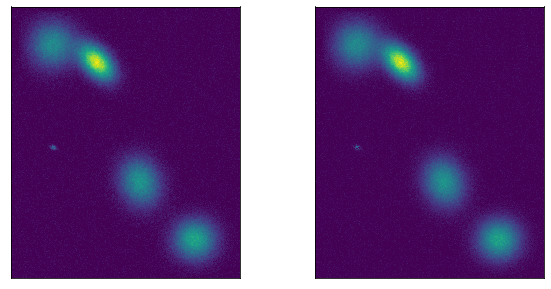

In [0]:
n = 16
fig = plt.figure(figsize=(10, 5))
ax_lst = fig.subplots(1, 2)

ax_lst[0].imshow(dineof3.original_tensor[:, :, n])
ax_lst[1].imshow(dineof3.reconstructed_tensor[:, :, n])

for ax in ax_lst:
    ax.set_xticks([])
    ax.set_yticks([])